# MITRE ATT&CK: Programmatic Analysis

## 🎯 Learning Objectives
By the end of this notebook, you will be able to:
- Load and query ATT&CK data programmatically using Python
- Build reusable functions to extract techniques, groups, and software
- Profile threat actors and analyze their Tactics, Techniques, and Procedures (TTPs)
- Identify the most commonly used techniques across all threat groups
- Analyze malware and tool capabilities
- Discover detection gaps and blind spots in your security coverage

## 📚 Prerequisites
- Basic Python knowledge (functions, lists, dictionaries)
- Understanding of ATT&CK basics from Notebook 01
- Familiarity with data analysis concepts

---

## Setup and Data Loading

**What we're doing:** Setting up our Python environment by importing necessary libraries and configuring visualization tools.

**Why it matters:** These libraries provide the tools we need for data analysis (pandas), visualization (matplotlib, seaborn), graph analysis (networkx), and ATT&CK data manipulation (stix2).

In [ ]:
# ============================================================================
# STEP 1: Import Required Libraries
# ============================================================================
# Purpose: Load all Python libraries we'll need for ATT&CK analysis
#
# What each library does:
# - pandas: Organize data in tables (DataFrames) for easy analysis
# - matplotlib & seaborn: Create beautiful charts and visualizations
# - networkx: Analyze relationships between ATT&CK objects
# - stix2: Work with ATT&CK's native STIX data format
# - requests: Download ATT&CK data from the internet
# - Counter & defaultdict: Count and organize data efficiently

import pandas as pd                    # Data analysis and tables
import matplotlib.pyplot as plt        # Create plots and charts
import seaborn as sns                  # Enhanced visualizations
import networkx as nx                  # Graph/network analysis
from stix2 import MemoryStore, Filter  # ATT&CK data handling
import requests                        # Download data from web
import json                            # Parse JSON data
from collections import Counter, defaultdict  # Data organization tools
import warnings
warnings.filterwarnings('ignore')      # Hide unnecessary warnings

# Configure visualization settings for better-looking charts
plt.style.use('seaborn-v0_8-darkgrid')  # Modern chart style
sns.set_palette("Set2")                  # Color-blind friendly colors
%matplotlib inline                       # Display charts in notebook

print("✓ Libraries imported successfully!")
print("  Ready to analyze ATT&CK data!")

✓ Libraries imported successfully!


In [ ]:
# ============================================================================
# STEP 2: Load ATT&CK Data from MITRE's Repository
# ============================================================================
# Purpose: Download the latest ATT&CK Enterprise matrix data
#
# How it works:
# 1. We fetch data from MITRE's official GitHub repository
# 2. The data comes in STIX format (Structured Threat Information eXpression)
# 3. We store it in a MemoryStore for easy querying
#
# What is STIX?
# - A standardized format for sharing cyber threat intelligence
# - ATT&CK objects (techniques, groups, software) are stored as STIX objects
# - Relationships between objects (e.g., "APT29 uses Mimikatz") are also STIX objects

def load_attack_data():
    """
    Load ATT&CK Enterprise data from MITRE's GitHub repository
    
    Returns:
        attack_store: A queryable database of ATT&CK objects
        attack_objects: Raw list of all ATT&CK objects
    """
    print("📥 Loading ATT&CK Enterprise data from MITRE...")
    print("   Source: MITRE CTI GitHub Repository")
    
    # URL to the latest Enterprise ATT&CK data (JSON format)
    url = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"
    
    try:
        # Download the data
        response = requests.get(url)
        response.raise_for_status()  # Check for download errors
        
        # Parse the JSON data
        attack_data = response.json()
        
        # Create a MemoryStore for easy querying
        # Think of this as a mini database in memory
        attack_store = MemoryStore(stix_data=attack_data["objects"])
        
        print(f"✓ Successfully loaded {len(attack_data['objects'])} ATT&CK objects")
        print(f"   This includes: techniques, groups, software, mitigations, and relationships")
        
        return attack_store, attack_data["objects"]
    
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        print("   Check your internet connection and try again")
        return None, None

# Execute the function to load data
attack, attack_objects = load_attack_data()

Loading ATT&CK Enterprise data...
✓ Loaded 24771 ATT&CK objects
✓ Loaded 24771 ATT&CK objects


---

## Part 1: Building Helper Functions

**What we're doing:** Creating reusable Python functions to extract specific types of ATT&CK objects.

**Why helper functions?**
- **Reusability:** Write once, use many times throughout the notebook
- **Clean Code:** Makes our analysis code shorter and easier to read
- **Error Prevention:** Centralized filtering logic (removes deprecated/revoked items)
- **Flexibility:** Easy to modify behavior in one place

**Key Concepts:**
- **Techniques:** Attack methods (e.g., "Phishing", "PowerShell", "Credential Dumping")
- **Sub-techniques:** More specific variations (e.g., T1566.001 "Spearphishing Attachment")
- **Groups:** Threat actors/APT groups (e.g., APT29, Lazarus Group)
- **Software:** Malware and tools (e.g., Cobalt Strike, Mimikatz)
- **Revoked/Deprecated:** Outdated entries we should exclude from analysis

In [ ]:
# ============================================================================
# HELPER FUNCTION 1: Get All Techniques
# ============================================================================
def get_all_techniques(attack_store, include_subtechniques=False):
    """
    Extract all techniques from ATT&CK, with optional filtering
    
    Parameters:
        attack_store: The ATT&CK data store (from load_attack_data)
        include_subtechniques: If True, includes sub-techniques like T1234.567
                               If False, only parent techniques like T1234
    
    Returns:
        List of technique STIX objects (dictionaries containing technique data)
    
    Example:
        Parent technique: T1566 - Phishing
        Sub-techniques: T1566.001 - Spearphishing Attachment
                       T1566.002 - Spearphishing Link
    """
    # Query for all attack-patterns (ATT&CK techniques are stored as attack-patterns in STIX)
    techniques = attack_store.query([Filter("type", "=", "attack-pattern")])
    
    filtered = []
    for tech in techniques:
        # Skip entries that have been revoked or deprecated by MITRE
        # (These are old versions or techniques that have been replaced)
        if tech.get('revoked') or tech.get('x_mitre_deprecated'):
            continue
        
        # Get the technique ID (e.g., "T1566" or "T1566.001")
        tech_id = tech['external_references'][0]['external_id']
        
        # Filter based on whether we want sub-techniques
        # Sub-techniques contain a period (.) in their ID
        if not include_subtechniques and '.' in tech_id:
            continue  # Skip sub-techniques if we only want parents
        
        filtered.append(tech)
    
    return filtered


# ============================================================================
# HELPER FUNCTION 2: Get All Threat Groups
# ============================================================================
def get_all_groups(attack_store):
    """
    Extract all threat groups/actors from ATT&CK
    
    Returns:
        List of group STIX objects
    
    Note: In STIX format, groups are called "intrusion-set" objects
    Examples: APT29, Lazarus Group, FIN7
    """
    # Query for all intrusion-sets (threat groups)
    groups = attack_store.query([Filter("type", "=", "intrusion-set")])
    
    filtered = []
    for group in groups:
        # Skip revoked/deprecated groups
        if group.get('revoked') or group.get('x_mitre_deprecated'):
            continue
        filtered.append(group)
    
    return filtered


# ============================================================================
# HELPER FUNCTION 3: Get All Software (Malware and Tools)
# ============================================================================
def get_all_software(attack_store):
    """
    Extract all software from ATT&CK (both malware and tools)
    
    Returns:
        List of software STIX objects
    
    What's the difference?
    - Malware: Malicious software (e.g., ransomware, trojans, backdoors)
    - Tools: Legitimate software misused by attackers (e.g., PowerShell, PsExec)
    
    Examples: Cobalt Strike, Mimikatz, Emotet, PowerShell Empire
    """
    # Query for both malware AND tools (using "in" filter for multiple types)
    software = attack_store.query([
        Filter("type", "in", ["malware", "tool"])
    ])
    
    filtered = []
    for sw in software:
        # Skip revoked/deprecated software
        if sw.get('revoked') or sw.get('x_mitre_deprecated'):
            continue
        filtered.append(sw)
    
    return filtered


# ============================================================================
# TEST THE FUNCTIONS - Let's see what we got!
# ============================================================================
print("🔍 Extracting ATT&CK objects using our helper functions...\n")

techniques = get_all_techniques(attack)
groups = get_all_groups(attack)
software = get_all_software(attack)

print(f"📊 ATT&CK Object Counts (Active/Non-Deprecated Only):")
print(f"{'='*60}")
print(f"  • Techniques (parent only):  {len(techniques):>4}")
print(f"  • Threat Groups:             {len(groups):>4}")
print(f"  • Software (Malware + Tools): {len(software):>4}")
print(f"{'='*60}")

# Show example technique
if techniques:
    example = techniques[0]
    print(f"\n📌 Example Technique:")
    print(f"   ID:   {example['external_references'][0]['external_id']}")
    print(f"   Name: {example['name']}")
    print(f"   Type: {example['type']}")

print("\n✓ Helper functions are working correctly!")


📊 ATT&CK Object Counts:
  • Techniques (parent): 216
  • Groups: 172
  • Software: 784


---

## Part 2: Threat Group Profiling

**What we're doing:** Building a comprehensive profile of a specific threat actor.

**Real-World Application:**
Imagine you're a security analyst and your organization receives a threat intelligence report mentioning "APT29" as a threat to your industry. You need to quickly understand:
- What techniques does APT29 use?
- Which tactics do they focus on?
- What should we prioritize detecting?

**What you'll learn:**
- How to query relationships in ATT&CK (Group → uses → Technique)
- How to organize techniques by tactic (Kill Chain phase)
- How to create actionable threat intelligence profiles

**Key Terms:**
- **TTPs:** Tactics, Techniques, and Procedures (the "how" of an attack)
- **Relationships:** Connections between objects (e.g., "APT29 uses PowerShell")
- **Tactics:** The "why" behind a technique (e.g., "Initial Access", "Defense Evasion")

In [ ]:
# ============================================================================
# THREAT GROUP PROFILING FUNCTION
# ============================================================================
def profile_threat_group(attack_store, group_name_or_id):
    """
    Create a comprehensive profile of a threat group including all their TTPs
    
    Parameters:
        attack_store: The ATT&CK data store
        group_name_or_id: Group name (e.g., "APT29") or ID (e.g., "G0016")
    
    Returns:
        Dictionary containing:
        - Basic info (ID, name, aliases, description)
        - List of techniques used
        - Techniques organized by tactic
    
    How it works:
    1. Search for the group in ATT&CK
    2. Find all "uses" relationships (Group → uses → Technique)
    3. Extract technique details
    4. Organize techniques by their tactical purpose
    """
    
    # -----------------------------------------------------------------------
    # STEP 1: Search for the target group
    # -----------------------------------------------------------------------
    print(f"🔍 Searching for group: {group_name_or_id}...")
    
    groups = get_all_groups(attack_store)
    
    target_group = None
    for group in groups:
        group_id = group['external_references'][0]['external_id']
        group_name = group['name']
        aliases = group.get('aliases', [])  # Alternative names for the group
        
        # Check if search matches ID, name, or any alias
        if (group_name_or_id.upper() in [group_id, group_name.upper()] or
            any(group_name_or_id.upper() in alias.upper() for alias in aliases)):
            target_group = group
            break
    
    # If not found, return early
    if not target_group:
        print(f"❌ Group '{group_name_or_id}' not found in ATT&CK!")
        print(f"   Try searching on https://attack.mitre.org/groups/")
        return None
    
    # -----------------------------------------------------------------------
    # STEP 2: Extract basic group information
    # -----------------------------------------------------------------------
    group_id = target_group['external_references'][0]['external_id']
    group_name = target_group['name']
    description = target_group.get('description', 'No description available')
    aliases = target_group.get('aliases', [])
    
    # Display header
    print(f"\n{'='*80}")
    print(f"🎯 Threat Group Profile: {group_name} ({group_id})")
    print(f"{'='*80}\n")
    
    print(f"📝 Aliases: {', '.join(aliases) if len(aliases) > 1 else 'None'}")
    print(f"\n📄 Description:")
    print(f"   {description[:500]}{'...' if len(description) > 500 else ''}\n")
    
    # -----------------------------------------------------------------------
    # STEP 3: Find all techniques used by this group
    # -----------------------------------------------------------------------
    # In ATT&CK, relationships connect objects
    # We're looking for: source=this_group, relationship="uses", target=technique
    
    print("🔗 Querying relationships...")
    relationships = attack_store.query([
        Filter("type", "=", "relationship"),
        Filter("source_ref", "=", target_group['id']),  # Source = our group
        Filter("relationship_type", "=", "uses")         # Relationship = "uses"
    ])
    
    print(f"   Found {len(relationships)} 'uses' relationships")
    
    # -----------------------------------------------------------------------
    # STEP 4: Process relationships and organize techniques by tactic
    # -----------------------------------------------------------------------
    # defaultdict automatically creates empty lists for new tactics
    techniques_by_tactic = defaultdict(list)
    technique_details = []
    
    for rel in relationships:
        # Get the target object (what the group "uses")
        target_obj = attack_store.get(rel['target_ref'])
        
        # We only want techniques (attack-patterns), not software
        if target_obj and target_obj['type'] == 'attack-pattern':
            tech_id = target_obj['external_references'][0]['external_id']
            tech_name = target_obj['name']
            
            # Get tactics (kill chain phases) for this technique
            # A technique can belong to multiple tactics!
            # Example: "PowerShell" is used in Execution AND Defense Evasion
            tactics = [phase['phase_name'] for phase in target_obj.get('kill_chain_phases', [])]
            
            # Store technique details
            technique_details.append({
                'ID': tech_id,
                'Name': tech_name,
                'Tactics': tactics
            })
            
            # Add technique to each relevant tactic category
            for tactic in tactics:
                techniques_by_tactic[tactic].append(f"{tech_id} - {tech_name}")
    
    print(f"   Extracted {len(technique_details)} unique techniques\n")
    
    # -----------------------------------------------------------------------
    # STEP 5: Display techniques organized by tactic (Kill Chain order)
    # -----------------------------------------------------------------------
    print(f"{'='*80}")
    print(f"📋 TECHNIQUES BY TACTIC (Kill Chain Order)")
    print(f"{'='*80}\n")
    
    # ATT&CK tactics in chronological order (how attacks typically progress)
    tactic_order = [
        'reconnaissance',        # Gathering information about the target
        'resource-development',  # Setting up infrastructure
        'initial-access',        # Getting into the network
        'execution',             # Running malicious code
        'persistence',           # Maintaining foothold
        'privilege-escalation',  # Getting higher permissions
        'defense-evasion',       # Avoiding detection
        'credential-access',     # Stealing passwords/credentials
        'discovery',             # Learning about the environment
        'lateral-movement',      # Moving to other systems
        'collection',            # Gathering data to steal
        'command-and-control',   # Communication with attacker infrastructure
        'exfiltration',          # Stealing data
        'impact'                 # Disruption/destruction
    ]
    
    for tactic in tactic_order:
        if tactic in techniques_by_tactic:
            # Format tactic name nicely (replace hyphens with spaces, capitalize)
            print(f"🔹 {tactic.replace('-', ' ').title()}:")
            
            # Show up to 5 techniques per tactic (to avoid overwhelming output)
            for tech in techniques_by_tactic[tactic][:5]:
                print(f"     • {tech}")
            
            # If there are more, indicate how many
            if len(techniques_by_tactic[tactic]) > 5:
                remaining = len(techniques_by_tactic[tactic]) - 5
                print(f"     ... and {remaining} more")
            print()  # Blank line between tactics
    
    # -----------------------------------------------------------------------
    # STEP 6: Return structured data for further analysis
    # -----------------------------------------------------------------------
    return {
        'group_id': group_id,
        'group_name': group_name,
        'aliases': aliases,
        'description': description,
        'techniques': technique_details,
        'techniques_by_tactic': techniques_by_tactic
    }


# ============================================================================
# EXAMPLE: Profile APT29 (Cozy Bear)
# ============================================================================
# APT29 is a Russian state-sponsored threat group
# Known for sophisticated attacks against government and private sector targets

print("="*80)
print("EXAMPLE: Profiling APT29 (Cozy Bear)")
print("="*80 + "\n")

apt29_profile = profile_threat_group(attack, "APT29")


Threat Group Profile: APT29 (G0016)

Aliases: APT29, IRON RITUAL, IRON HEMLOCK, NobleBaron, Dark Halo, NOBELIUM, UNC2452, YTTRIUM, The Dukes, Cozy Bear, CozyDuke, SolarStorm, Blue Kitsune, UNC3524, Midnight Blizzard

Description:
[APT29](https://attack.mitre.org/groups/G0016) is threat group that has been attributed to Russia's Foreign Intelligence Service (SVR).(Citation: White House Imposing Costs RU Gov April 2021)(Citation: UK Gov Malign RIS Activity April 2021) They have operated since at least 2008, often targeting government networks in Europe and NATO member countries, research institutes, and think tanks. [APT29](https://attack.mitre.org/groups/G0016) reportedly compromised the Democratic National Committee star...

Techniques Used: 66


Reconnaissance:
  • T1595.002 - Vulnerability Scanning

Resource Development:
  • T1588.002 - Tool
  • T1587.003 - Digital Certificates
  • T1587.001 - Malware
  • T1583.006 - Web Services
  • T1586.003 - Cloud Accounts
  ... and 1 more

Init

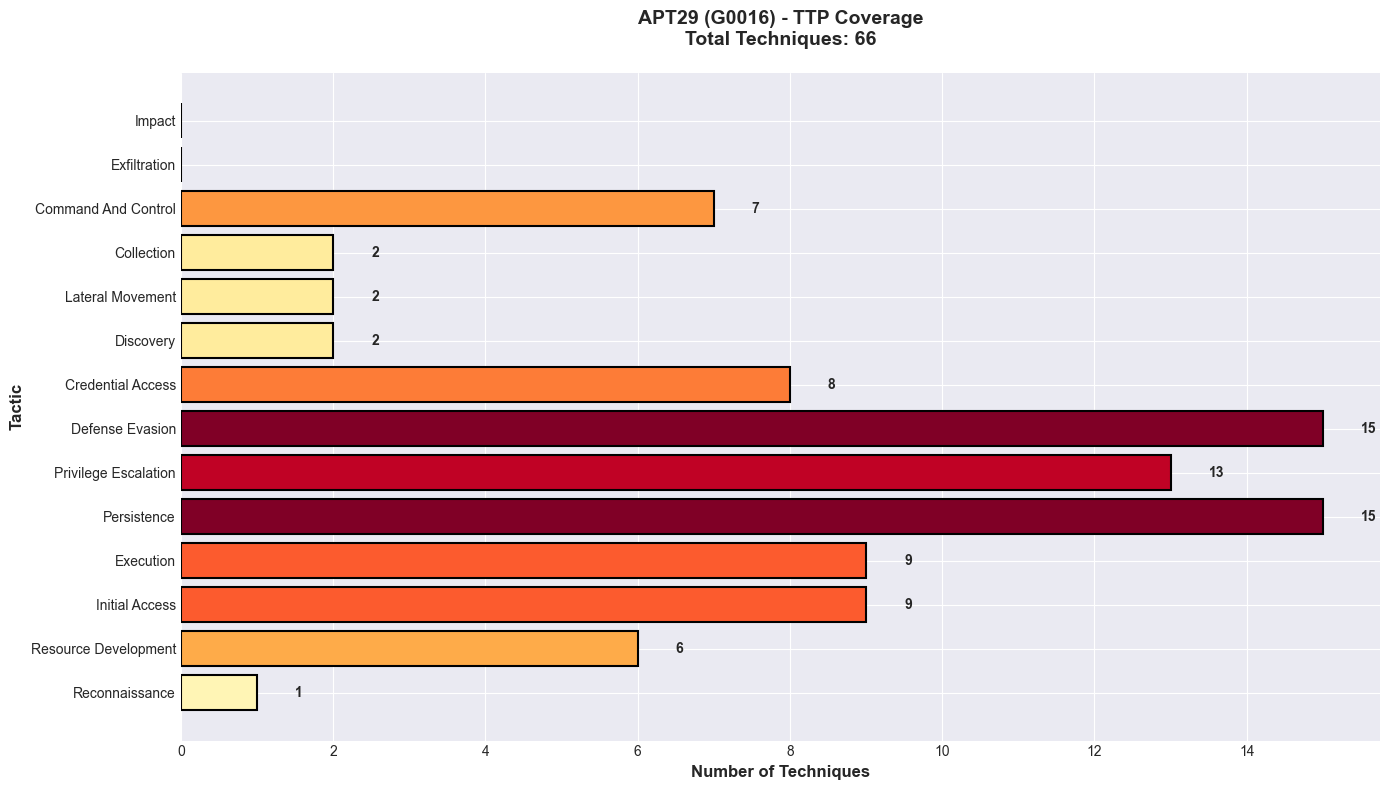

In [ ]:
# ============================================================================
# VISUALIZE GROUP TTP COVERAGE
# ============================================================================
# Purpose: Create a visual representation of which tactics the group uses most
#
# Why visualize?
# - Quickly identify the group's focus areas
# - Compare coverage across tactics
# - Prioritize defenses based on group behavior

if apt29_profile:
    print("📊 Creating visualization of TTP coverage...\n")
    
    # Count techniques per tactic
    tactic_counts = {tactic: len(techs) 
                    for tactic, techs in apt29_profile['techniques_by_tactic'].items()}
    
    # Order tactics by Kill Chain sequence (not alphabetically!)
    tactic_order = [
        'reconnaissance', 'resource-development', 'initial-access', 'execution',
        'persistence', 'privilege-escalation', 'defense-evasion', 'credential-access',
        'discovery', 'lateral-movement', 'collection', 'command-and-control',
        'exfiltration', 'impact'
    ]
    
    # Create sorted data: (Tactic Name, Count)
    sorted_tactics = [(t.replace('-', ' ').title(), tactic_counts.get(t, 0)) 
                     for t in tactic_order]
    tactics_labels, counts = zip(*sorted_tactics)
    
    # -----------------------------------------------------------------------
    # Create a horizontal bar chart (easier to read tactic names)
    # -----------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Color bars based on count (darker = more techniques)
    # This creates a "heat map" effect
    max_count = max(counts) if max(counts) > 0 else 1
    colors = plt.cm.YlOrRd([c/max_count for c in counts])  # Yellow to Red gradient
    
    bars = ax.barh(tactics_labels, counts, color=colors, 
                   edgecolor='black', linewidth=1.5)
    
    # Labels and title
    ax.set_xlabel('Number of Techniques', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tactic', fontsize=12, fontweight='bold')
    ax.set_title(
        f"{apt29_profile['group_name']} ({apt29_profile['group_id']}) - TTP Coverage\n"
        f"Total Techniques: {len(apt29_profile['techniques'])}", 
        fontsize=14, fontweight='bold', pad=20
    )
    
    # Add value labels on each bar
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # -----------------------------------------------------------------------
    # Interpretation Help
    # -----------------------------------------------------------------------
    print("\n💡 How to Read This Chart:")
    print("   • Longer bars = More techniques in that tactic")
    print("   • Darker colors = Higher technique concentration")
    print("   • Gaps (zero techniques) = Tactic not used by this group")
    print("\n🎯 Defensive Priority:")
    print(f"   Focus detection efforts on the top 3-5 tactics with most techniques")
    print(f"   These represent the group's primary attack patterns")
else:
    print("⚠️  No profile data available to visualize")

---

## Exercise 1: Compare Multiple Threat Groups

**Objective:** Understand how different threat groups differ in their attack patterns.

**Real-World Scenario:**
Your organization operates in the technology sector. Threat intelligence reports indicate that APT28, APT29, and Lazarus Group have all targeted similar organizations. You need to understand:
- How do these groups differ in their tactics?
- Which techniques are common across all three?
- Where should defenses be prioritized?

**What we'll do:**
1. Profile multiple groups (APT28, APT29, Lazarus Group)
2. Compare their tactic-level coverage side-by-side
3. Identify patterns and differences

**Learning Goal:** Understand that even sophisticated groups have different "signatures" - patterns in how they operate.

In [ ]:
# ============================================================================
# STEP 1: Profile Multiple Groups
# ============================================================================
# Purpose: Analyze several threat groups to compare their behaviors
#
# Groups we're analyzing:
# - APT29 (Cozy Bear): Russian state-sponsored, sophisticated techniques
# - APT28 (Fancy Bear): Russian military intelligence, targeted attacks
# - Lazarus Group: North Korean state-sponsored, financially motivated + espionage

print("🔄 Profiling Multiple Threat Groups for Comparison\n")
print("="*80)

groups_to_analyze = ["APT29", "APT28", "Lazarus Group"]

# Dictionary to store all profiles
group_profiles = {}

for group_name in groups_to_analyze:
    print(f"\n{'─'*80}")
    print(f"📍 Analyzing: {group_name}")
    print(f"{'─'*80}")
    
    # Profile the group using our function
    profile = profile_threat_group(attack, group_name)
    
    if profile:
        # Store the profile for comparison
        group_profiles[group_name] = profile
        print(f"✓ Profile complete for {profile['group_name']}")
    else:
        print(f"✗ Could not profile {group_name}")
    
    print("\n")

print("="*80)
print(f"✓ Successfully profiled {len(group_profiles)} groups")
print("="*80)


Analyzing: APT29

Threat Group Profile: APT29 (G0016)

Aliases: APT29, IRON RITUAL, IRON HEMLOCK, NobleBaron, Dark Halo, NOBELIUM, UNC2452, YTTRIUM, The Dukes, Cozy Bear, CozyDuke, SolarStorm, Blue Kitsune, UNC3524, Midnight Blizzard

Description:
[APT29](https://attack.mitre.org/groups/G0016) is threat group that has been attributed to Russia's Foreign Intelligence Service (SVR).(Citation: White House Imposing Costs RU Gov April 2021)(Citation: UK Gov Malign RIS Activity April 2021) They have operated since at least 2008, often targeting government networks in Europe and NATO member countries, research institutes, and think tanks. [APT29](https://attack.mitre.org/groups/G0016) reportedly compromised the Democratic National Committee star...

Techniques Used: 66


Reconnaissance:
  • T1595.002 - Vulnerability Scanning

Resource Development:
  • T1588.002 - Tool
  • T1587.003 - Digital Certificates
  • T1587.001 - Malware
  • T1583.006 - Web Services
  • T1586.003 - Cloud Accounts
  ..

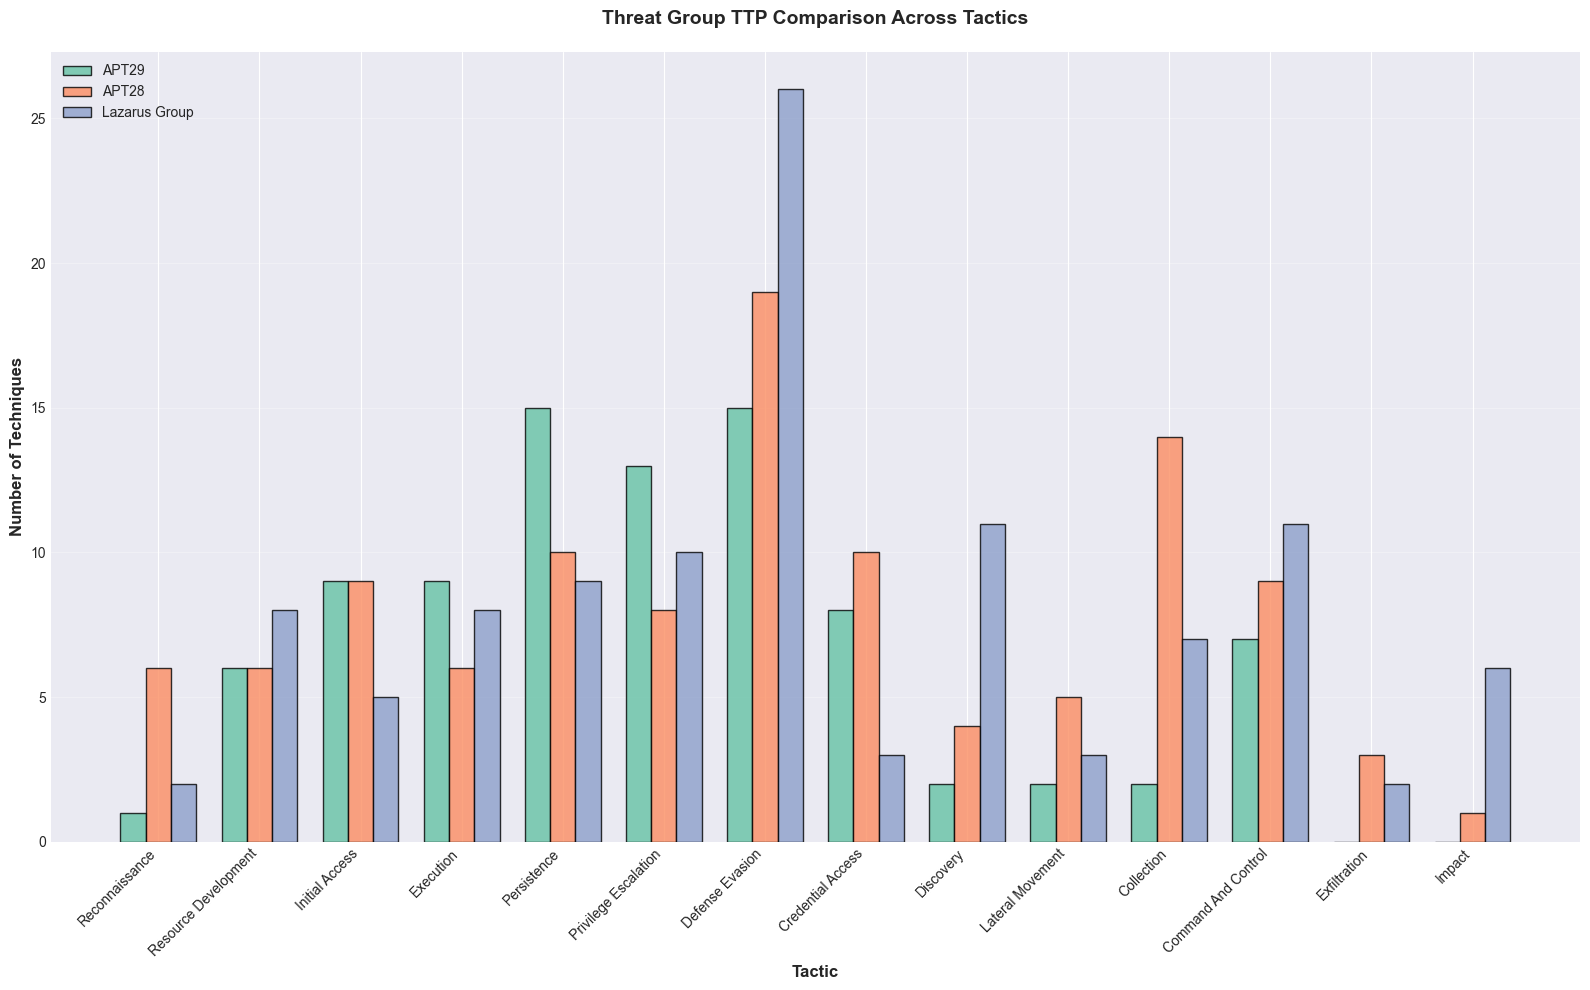


📊 Summary Statistics:

APT29 (G0016):
  • Total Techniques: 66
  • Tactics Covered: 12/14
  • Most Active Tactic: Persistence (15 techniques)

APT28 (G0007):
  • Total Techniques: 91
  • Tactics Covered: 14/14
  • Most Active Tactic: Defense Evasion (19 techniques)

Lazarus Group (G0032):
  • Total Techniques: 93
  • Tactics Covered: 14/14
  • Most Active Tactic: Defense Evasion (26 techniques)



In [ ]:
# ============================================================================
# STEP 2: Create Side-by-Side Comparison
# ============================================================================
# Purpose: Visualize how different groups use different tactics
#
# What we're comparing:
# - Each tactic's technique count across all groups
# - Which groups focus on which tactics
# - Overlap and differences in attack patterns

if group_profiles:
    print("📊 Creating comparison visualization...\n")
    
    # -----------------------------------------------------------------------
    # Build comparison data table
    # -----------------------------------------------------------------------
    comparison_data = []
    
    # Use standard Kill Chain order for tactics
    tactic_order = [
        'reconnaissance', 'resource-development', 'initial-access', 'execution',
        'persistence', 'privilege-escalation', 'defense-evasion', 'credential-access',
        'discovery', 'lateral-movement', 'collection', 'command-and-control',
        'exfiltration', 'impact'
    ]
    
    # For each tactic, count techniques per group
    for tactic in tactic_order:
        row = {'Tactic': tactic.replace('-', ' ').title()}
        
        # Add count for each group
        for group_name, profile in group_profiles.items():
            count = len(profile['techniques_by_tactic'].get(tactic, []))
            row[profile['group_name']] = count
        
        comparison_data.append(row)
    
    # Convert to DataFrame for easy manipulation
    comparison_df = pd.DataFrame(comparison_data)
    
    print("📋 Comparison Table (Techniques per Tactic):")
    print(comparison_df.to_string(index=False))
    print("\n")
    
    # -----------------------------------------------------------------------
    # Create grouped bar chart
    # -----------------------------------------------------------------------
    # This shows all groups side-by-side for each tactic
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    x = range(len(comparison_df))  # X-axis positions for tactics
    width = 0.25  # Width of each bar
    
    # Plot bars for each group
    for i, (group_name, profile) in enumerate(group_profiles.items()):
        # Calculate offset to place bars side-by-side
        offset = width * (i - len(group_profiles)/2 + 0.5)
        
        # Get technique counts for this group
        values = comparison_df[profile['group_name']].values
        
        # Create bars
        ax.bar([pos + offset for pos in x], values, width, 
               label=profile['group_name'], alpha=0.8, edgecolor='black')
    
    # Formatting
    ax.set_xlabel('Tactic', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Techniques', fontsize=12, fontweight='bold')
    ax.set_title('Threat Group TTP Comparison Across Tactics\n' + 
                'Compare which tactics each group emphasizes', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Tactic'], rotation=45, ha='right')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -----------------------------------------------------------------------
    # Print summary statistics
    # -----------------------------------------------------------------------
    print("\n" + "="*80)
    print("📊 SUMMARY STATISTICS")
    print("="*80 + "\n")
    
    for group_name, profile in group_profiles.items():
        print(f"🎯 {profile['group_name']} ({profile['group_id']}):")
        print(f"   • Total Techniques: {len(profile['techniques'])}")
        print(f"   • Tactics Covered: {len(profile['techniques_by_tactic'])}/14")
        
        # Find most used tactic for this group
        if profile['techniques_by_tactic']:
            max_tactic = max(profile['techniques_by_tactic'].items(), 
                           key=lambda x: len(x[1]))
            tactic_name = max_tactic[0].replace('-', ' ').title()
            tech_count = len(max_tactic[1])
            print(f"   • Most Active Tactic: {tactic_name} ({tech_count} techniques)")
        print()
    
    # -----------------------------------------------------------------------
    # Interpretation guide
    # -----------------------------------------------------------------------
    print("💡 How to Interpret This Comparison:")
    print("   • Taller bars = More techniques used in that tactic")
    print("   • Compare bar heights across groups to see differences")
    print("   • Similar patterns = Groups with similar attack methodologies")
    print("   • Different patterns = Groups with unique operational styles")
    print("\n🎯 Defensive Insight:")
    print("   • Tactics used by ALL groups = Universal defenses needed")
    print("   • Tactics unique to one group = Targeted threat hunting opportunity")
else:
    print("⚠️  No group profiles available for comparison")

---

## Part 3: Technique Popularity Analysis

**Objective:** Discover which techniques are most widely used across ALL threat groups.

**Why This Matters:**
Think of this as a "Top 10 Most Wanted" list for adversary techniques. If a technique is used by 50+ different threat groups, it means:
- ✅ It's effective and reliable (from attacker perspective)
- ✅ It's harder to attribute to a specific group
- ⚠️ **HIGH PRIORITY for detection and mitigation**

**Real-World Application:**
Security teams have limited resources. By identifying the most popular techniques, you can:
1. Prioritize detection rule development
2. Focus SOC analyst training
3. Implement high-impact security controls
4. Build defenses that work against many threats simultaneously

**What We'll Do:**
1. Count how many groups use each technique
2. Rank techniques by popularity
3. Visualize the top techniques
4. Identify "universal" techniques that all defenders should address

In [ ]:
# ============================================================================
# TECHNIQUE POPULARITY ANALYSIS
# ============================================================================
def analyze_technique_popularity(attack_store):
    """
    Determine which techniques are most commonly used across all threat groups
    
    How it works:
    1. Loop through every threat group
    2. Find all techniques each group uses
    3. Count total uses per technique
    4. Calculate percentage (what % of groups use this technique)
    
    Returns:
        DataFrame with columns: Technique_ID, Technique_Name, Groups_Using, Percentage
    """
    print("🔍 Analyzing technique popularity across all threat groups...")
    print("   This may take a moment...\n")
    
    # -----------------------------------------------------------------------
    # STEP 1: Get all groups
    # -----------------------------------------------------------------------
    groups = get_all_groups(attack_store)
    total_groups = len(groups)
    print(f"   Analyzing {total_groups} threat groups")
    
    # -----------------------------------------------------------------------
    # STEP 2: Count technique usage
    # -----------------------------------------------------------------------
    # Counter automatically tallies occurrences
    technique_usage = Counter()
    technique_names = {}  # Store names for later display
    
    # Loop through each group
    for group in groups:
        # Find all "uses" relationships for this group
        relationships = attack_store.query([
            Filter("type", "=", "relationship"),
            Filter("source_ref", "=", group['id']),
            Filter("relationship_type", "=", "uses")
        ])
        
        # Process each relationship
        for rel in relationships:
            target_obj = attack_store.get(rel['target_ref'])
            
            # Only count techniques (not software)
            if target_obj and target_obj['type'] == 'attack-pattern':
                tech_id = target_obj['external_references'][0]['external_id']
                tech_name = target_obj['name']
                
                # Increment counter for this technique
                technique_usage[tech_id] += 1
                
                # Remember the technique name
                technique_names[tech_id] = tech_name
    
    print(f"   Found {len(technique_usage)} unique techniques in use")
    
    # -----------------------------------------------------------------------
    # STEP 3: Create DataFrame for analysis
    # -----------------------------------------------------------------------
    popularity_data = []
    
    # Loop through techniques in order of popularity (most_common sorts for us)
    for tech_id, count in technique_usage.most_common():
        # Calculate what percentage of groups use this technique
        percentage = (count / total_groups) * 100
        
        popularity_data.append({
            'Technique_ID': tech_id,
            'Technique_Name': technique_names[tech_id],
            'Groups_Using': count,
            'Percentage': percentage
        })
    
    print(f"   ✓ Analysis complete!\n")
    
    return pd.DataFrame(popularity_data)


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================
print("="*80)
print("TECHNIQUE POPULARITY ANALYSIS")
print("="*80 + "\n")

popularity_df = analyze_technique_popularity(attack)

# -----------------------------------------------------------------------
# Display Top 20 Most Popular Techniques
# -----------------------------------------------------------------------
print(f"🏆 Top 20 Most Popular Techniques (By Threat Group Usage):\n")
print(f"{'='*80}")
print(popularity_df.head(20).to_string(index=False))
print(f"{'='*80}\n")

# -----------------------------------------------------------------------
# Key Insights
# -----------------------------------------------------------------------
print("🔍 Key Insights:")
print(f"   • Most popular technique: {popularity_df.iloc[0]['Technique_Name']}")
print(f"     Used by {popularity_df.iloc[0]['Groups_Using']} groups "
      f"({popularity_df.iloc[0]['Percentage']:.1f}% of all groups)")
print(f"\n   • Top 5 techniques account for attacks by:")
top_5_avg = popularity_df.head(5)['Percentage'].mean()
print(f"     {top_5_avg:.1f}% of threat groups on average")
print(f"\n   💡 These techniques should be HIGHEST PRIORITY for detection!")

Analyzing technique popularity across all threat groups...


Top 20 Most Popular Techniques:

Technique_ID                             Technique_Name  Groups_Using  Percentage
       T1105                      Ingress Tool Transfer            85   49.418605
   T1204.002                             Malicious File            84   48.837209
   T1059.001                                 PowerShell            83   48.255814
   T1588.002                                       Tool            79   45.930233
   T1566.001                   Spearphishing Attachment            77   44.767442
   T1059.003                      Windows Command Shell            71   41.279070
   T1036.005 Match Legitimate Resource Name or Location            59   34.302326
   T1071.001                              Web Protocols            56   32.558140
   T1547.001         Registry Run Keys / Startup Folder            55   31.976744
       T1082               System Information Discovery            55   31.976744
   T

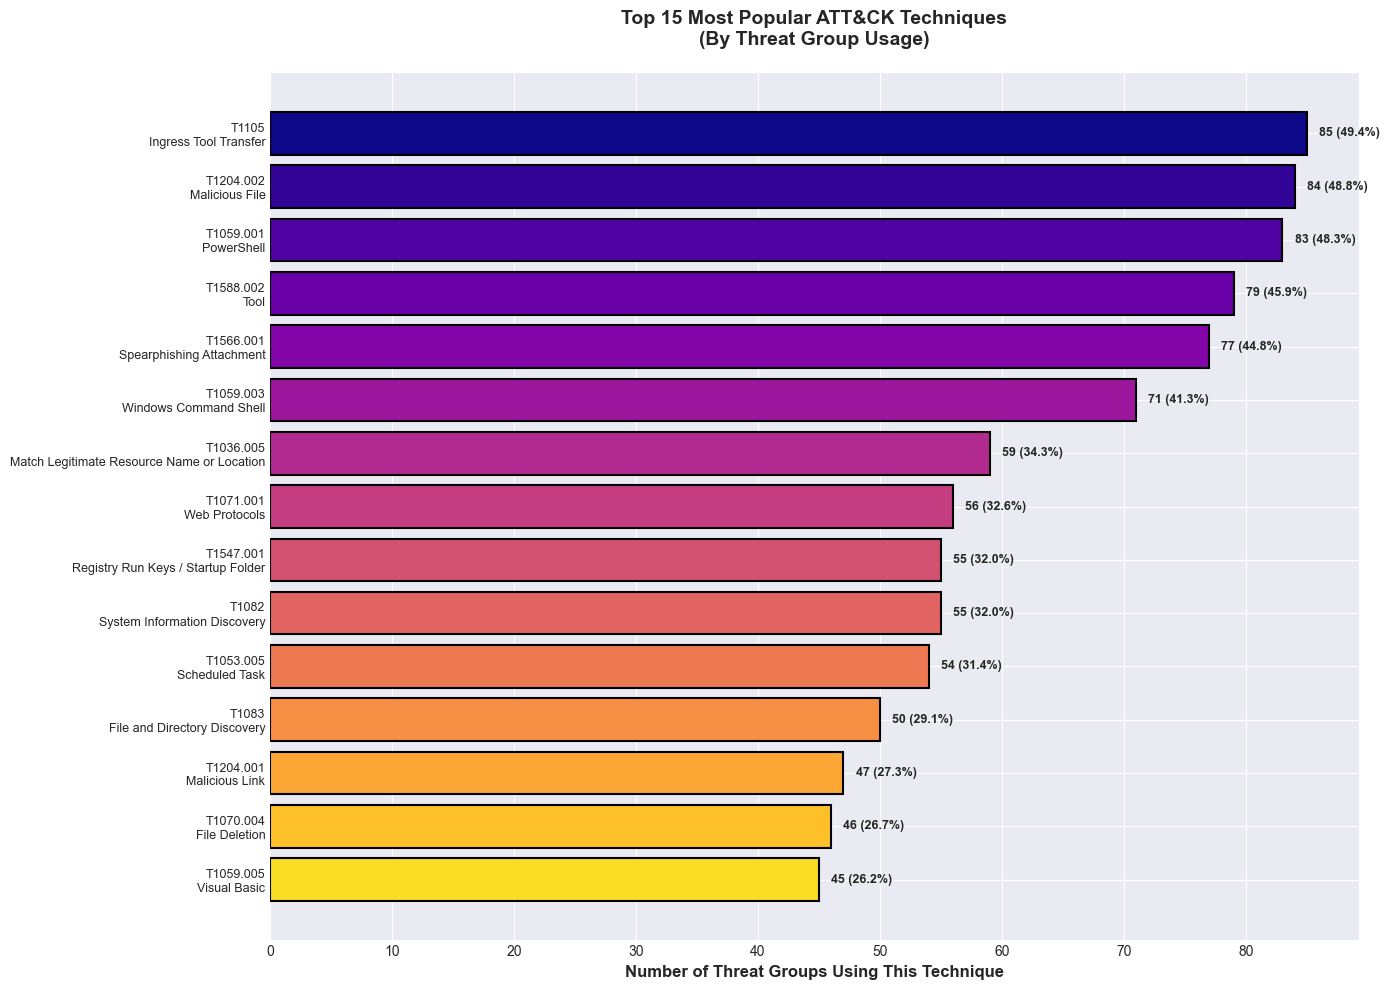


🔍 Key Insights:
  • Most popular: Ingress Tool Transfer (T1105)
    Used by 85 groups (49.4%)

  • These popular techniques should be HIGH PRIORITY for detection!


In [ ]:
# ============================================================================
# VISUALIZE TOP TECHNIQUES
# ============================================================================
# Purpose: Create a visual "Top 15" chart showing most popular techniques
#
# Why visualize?
# - Easier to communicate priorities to management
# - Quick visual reference for security teams
# - Helps in budget discussions ("defend against 70% of threats with these 15 rules")

print("\n📊 Creating visualization of top techniques...\n")

# Select top N techniques to visualize
top_n = 15
top_techniques = popularity_df.head(top_n)

# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# -----------------------------------------------------------------------
# Prepare data for plotting
# -----------------------------------------------------------------------
# Create labels combining ID and name (for clarity)
labels = [f"{row.Technique_ID}\n{row.Technique_Name}" 
          for row in top_techniques.itertuples()]

# Use a color gradient (darker = more popular)
colors = plt.cm.plasma(range(0, 256, 256 // len(top_techniques)))

# Create horizontal bars (easier to read technique names)
bars = ax.barh(range(len(top_techniques)), top_techniques['Groups_Using'], 
               color=colors, edgecolor='black', linewidth=1.5)

# -----------------------------------------------------------------------
# Formatting
# -----------------------------------------------------------------------
ax.set_yticks(range(len(top_techniques)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Number of Threat Groups Using This Technique', 
              fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Popular ATT&CK Techniques\n' + 
            '(Ranked by Threat Group Usage - Higher = More Important to Defend)', 
            fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars (show count + percentage)
for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = top_techniques.iloc[i]['Percentage']
    ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
           f'{int(width)} groups ({percentage:.1f}%)', 
           ha='left', va='center', fontweight='bold', fontsize=9)

ax.invert_yaxis()  # Most popular at top
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# Actionable Insights
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 DEFENSIVE RECOMMENDATIONS")
print("="*80 + "\n")

print("📌 Priority 1 - Critical Defenses:")
print(f"   The top technique is: {popularity_df.iloc[0]['Technique_Name']}")
print(f"   • Used by {popularity_df.iloc[0]['Groups_Using']} different threat groups")
print(f"   • Represents {popularity_df.iloc[0]['Percentage']:.1f}% of all threat activity")
print(f"   • Action: Ensure robust detection and mitigation for this technique\n")

print("📌 Priority 2 - High-Impact Defenses:")
print(f"   The top 5 techniques cover a large portion of threat activity")
print(f"   • Focus detection engineering here for maximum ROI")
print(f"   • Train SOC analysts to recognize these patterns")
print(f"   • Implement compensating controls if direct detection is hard\n")

print("📌 Priority 3 - Broad Coverage:")
print(f"   The top 15 techniques shown above collectively represent")
print(f"   the attack surface for the majority of threat groups")
print(f"   • Build a defense-in-depth strategy around these")
print(f"   • Use this list for tabletop exercises and purple team engagements\n")

print("💡 Remember:")
print("   Popular techniques ≠ Easy to detect")
print("   Some popular techniques (like PowerShell, WMI) are also legitimate")
print("   Focus on behavior detection, not just signature matching")

---

## Part 4: Software (Malware/Tools) Analysis

**Objective:** Understand malware and attack tools documented in ATT&CK.

**What's in ATT&CK Software?**
- **Malware:** Custom malicious software (e.g., Emotet, TrickBot, ransomware)
- **Tools:** Legitimate software misused by attackers (e.g., PowerShell, PsExec, Cobalt Strike)

**Why Analyze Software?**
1. **Threat Intelligence:** Understand capabilities of specific malware families
2. **Incident Response:** Quickly look up what a detected malware can do
3. **Purple Teaming:** Identify tools to simulate real adversary behavior
4. **Detection Development:** Know which techniques to detect when certain tools are found

**Real-World Example:**
If your EDR detects "Cobalt Strike" in your environment, you can immediately query ATT&CK to see:
- What techniques does Cobalt Strike implement?
- What should we look for next?
- What data might be at risk?

**What We'll Do:**
1. Profile specific malware/tools (example: Cobalt Strike)
2. Find the most "versatile" software (implements many techniques)
3. Understand the relationship: Software → implements → Techniques

In [ ]:
# ============================================================================
# SOFTWARE ANALYSIS FUNCTION
# ============================================================================
def analyze_software(attack_store, software_name):
    """
    Get comprehensive details about specific malware or tool
    
    Parameters:
        attack_store: The ATT&CK data store
        software_name: Name of the software (e.g., "Cobalt Strike", "Mimikatz")
    
    Returns:
        Dictionary with software details and implemented techniques
    
    How it works:
    1. Search for the software in ATT&CK
    2. Find all "uses" relationships (Software → uses → Technique)
    3. Display capabilities and techniques
    """
    
    print(f"🔍 Searching for software: {software_name}...")
    
    # -----------------------------------------------------------------------
    # STEP 1: Search for the software
    # -----------------------------------------------------------------------
    software_list = get_all_software(attack_store)
    
    target_software = None
    for sw in software_list:
        sw_name = sw['name']
        sw_id = sw['external_references'][0]['external_id']
        
        # Match by name or ID
        if software_name.upper() in sw_name.upper() or software_name.upper() == sw_id:
            target_software = sw
            break
    
    # If not found
    if not target_software:
        print(f"❌ Software '{software_name}' not found in ATT&CK!")
        print(f"   Try searching on https://attack.mitre.org/software/")
        return None
    
    # -----------------------------------------------------------------------
    # STEP 2: Extract software details
    # -----------------------------------------------------------------------
    sw_id = target_software['external_references'][0]['external_id']
    sw_name = target_software['name']
    sw_type = target_software['type']  # 'malware' or 'tool'
    description = target_software.get('description', 'No description available')
    
    print(f"\n{'='*80}")
    print(f"🛠️  Software Profile: {sw_name} ({sw_id})")
    print(f"{'='*80}")
    print(f"📦 Type: {sw_type.title()}")
    print(f"{'='*80}\n")
    
    print(f"📄 Description:")
    print(f"   {description[:400]}{'...' if len(description) > 400 else ''}\n")
    
    # -----------------------------------------------------------------------
    # STEP 3: Find techniques implemented by this software
    # -----------------------------------------------------------------------
    print(f"🔗 Querying implemented techniques...")
    
    # Find "uses" relationships where this software is the source
    relationships = attack_store.query([
        Filter("type", "=", "relationship"),
        Filter("source_ref", "=", target_software['id']),
        Filter("relationship_type", "=", "uses")
    ])
    
    techniques = []
    for rel in relationships:
        target_obj = attack_store.get(rel['target_ref'])
        
        # Only count techniques (software can also "use" other software)
        if target_obj and target_obj['type'] == 'attack-pattern':
            tech_id = target_obj['external_references'][0]['external_id']
            tech_name = target_obj['name']
            techniques.append(f"{tech_id} - {tech_name}")
    
    print(f"   Found {len(techniques)} implemented techniques\n")
    
    # -----------------------------------------------------------------------
    # STEP 4: Display techniques
    # -----------------------------------------------------------------------
    print(f"{'='*80}")
    print(f"⚙️  IMPLEMENTED TECHNIQUES ({len(techniques)} total)")
    print(f"{'='*80}\n")
    
    if techniques:
        # Show first 10 techniques
        for tech in techniques[:10]:
            print(f"  • {tech}")
        
        # Indicate if there are more
        if len(techniques) > 10:
            print(f"\n  ... and {len(techniques) - 10} more techniques")
    else:
        print("  No techniques documented for this software")
    
    print(f"\n{'='*80}")
    
    # -----------------------------------------------------------------------
    # STEP 5: Return structured data
    # -----------------------------------------------------------------------
    return {
        'id': sw_id,
        'name': sw_name,
        'type': sw_type,
        'techniques': techniques
    }


# ============================================================================
# EXAMPLE: Analyze Cobalt Strike
# ============================================================================
# Cobalt Strike is a legitimate penetration testing tool frequently misused
# by threat actors. It's one of the most versatile and capable tools in ATT&CK.

print("="*80)
print("EXAMPLE: Analyzing Cobalt Strike")
print("="*80 + "\n")

cobalt_strike = analyze_software(attack, "Cobalt Strike")

if cobalt_strike:
    print("\n💡 Why This Matters:")
    print(f"   If you detect {cobalt_strike['name']} in your environment,")
    print(f"   you now know it can implement {len(cobalt_strike['techniques'])} different techniques.")
    print(f"   This helps prioritize incident response and threat hunting activities.")


Software Profile: Cobalt Strike (S0154)
Type: Malware

Description:
[Cobalt Strike](https://attack.mitre.org/software/S0154) is a commercial, full-featured, remote access tool that bills itself as “adversary simulation software designed to execute targeted attacks and emulate the post-exploitation actions of advanced threat actors”. Cobalt Strike’s interactive post-exploit capabilities cover the full range of ATT&CK tactics, all executed within a single, integrate...

Techniques Implemented (72):
  • T1090.004 - Domain Fronting
  • T1548.003 - Sudo and Sudo Caching
  • T1553.002 - Code Signing
  • T1059.007 - JavaScript
  • T1021.001 - Remote Desktop Protocol
  • T1106 - Native API
  • T1550.002 - Pass the Hash
  • T1078.002 - Domain Accounts
  • T1027.005 - Indicator Removal from Tools
  • T1548.002 - Bypass User Account Control
  ... and 62 more


In [ ]:
# ============================================================================
# FIND MOST VERSATILE MALWARE/TOOLS
# ============================================================================
# Purpose: Identify which software implements the most techniques
#
# Why this matters:
# - Versatile tools = Greater threat if deployed
# - Common in advanced attacks (multi-stage, multi-purpose)
# - High priority for detection and threat hunting

print("\n" + "="*80)
print("ANALYZING ALL SOFTWARE BY TECHNIQUE COVERAGE")
print("="*80 + "\n")

print("🔄 Processing all malware and tools in ATT&CK...")

software_list = get_all_software(attack)
software_coverage = []

# -----------------------------------------------------------------------
# Count techniques for each software
# -----------------------------------------------------------------------
for sw in software_list:
    sw_id = sw['external_references'][0]['external_id']
    sw_name = sw['name']
    sw_type = sw['type']  # 'malware' or 'tool'
    
    # Find all techniques this software uses
    relationships = attack.query([
        Filter("type", "=", "relationship"),
        Filter("source_ref", "=", sw['id']),
        Filter("relationship_type", "=", "uses")
    ])
    
    # Count only techniques (not other software)
    technique_count = sum(1 for rel in relationships 
                         if attack.get(rel['target_ref']) and 
                         attack.get(rel['target_ref'])['type'] == 'attack-pattern')
    
    software_coverage.append({
        'ID': sw_id,
        'Name': sw_name,
        'Type': sw_type.title(),
        'Techniques': technique_count
    })

# -----------------------------------------------------------------------
# Create DataFrame and sort by technique count
# -----------------------------------------------------------------------
software_df = pd.DataFrame(software_coverage).sort_values('Techniques', ascending=False)

print(f"✓ Analyzed {len(software_df)} software entries\n")

# -----------------------------------------------------------------------
# Display top 15 most versatile
# -----------------------------------------------------------------------
print("🏆 Top 15 Most Versatile Malware/Tools:")
print("   (Ranked by number of ATT&CK techniques implemented)\n")
print("="*80)
print(software_df.head(15).to_string(index=False))
print("="*80 + "\n")

# -----------------------------------------------------------------------
# Insights
# -----------------------------------------------------------------------
print("💡 Key Insights:")
print(f"   • Most versatile: {software_df.iloc[0]['Name']}")
print(f"     Implements {software_df.iloc[0]['Techniques']} different techniques")
print(f"     Type: {software_df.iloc[0]['Type']}")
print(f"\n   • Average technique count: {software_df['Techniques'].mean():.1f}")
print(f"   • Median technique count: {software_df['Techniques'].median():.0f}")

# Separate stats for malware vs tools
malware_df = software_df[software_df['Type'] == 'Malware']
tools_df = software_df[software_df['Type'] == 'Tool']

print(f"\n   📊 Breakdown:")
print(f"      • Malware entries: {len(malware_df)}, avg techniques: {malware_df['Techniques'].mean():.1f}")
print(f"      • Tool entries: {len(tools_df)}, avg techniques: {tools_df['Techniques'].mean():.1f}")

print(f"\n🎯 Defensive Implication:")
print(f"   Tools at the top of this list are 'Swiss Army knives' for attackers")
print(f"   Detecting these should trigger high-priority alerts and immediate investigation")

Analyzing software by technique coverage...

Top 15 Most Versatile Malware/Tools:

   ID          Name    Type  Techniques
S0363        Empire    Tool          73
S0260    InvisiMole Malware          73
S0154 Cobalt Strike Malware          72
S0650        QakBot Malware          71
S1111      DarkGate Malware          58
S0266      TrickBot Malware          55
S0692 SILENTTRINITY    Tool          53
S0534         Bazar Malware          51
S0013         PlugX Malware          49
S0367        Emotet Malware          47
S0455     Metamorfo Malware          46
S0198       NETWIRE Malware          45
S0603       Stuxnet Malware          44
S1239     TONESHELL Malware          43
S0531   Grandoreiro Malware          43
Top 15 Most Versatile Malware/Tools:

   ID          Name    Type  Techniques
S0363        Empire    Tool          73
S0260    InvisiMole Malware          73
S0154 Cobalt Strike Malware          72
S0650        QakBot Malware          71
S1111      DarkGate Malware          58

---

## Part 5: Detection Gap Analysis

**Objective:** Identify techniques that are difficult to detect or lack documented detection methods.

**The Detection Challenge:**
Not all techniques are equally detectable. Some challenges include:
- **Limited Telemetry:** No log sources capture the activity
- **High False Positives:** Technique overlaps with legitimate activity
- **Evasion Techniques:** Designed to avoid detection mechanisms
- **Resource Intensive:** Detection requires expensive monitoring

**Why This Matters:**
These "detection gaps" represent **blind spots** in your security coverage. Understanding them helps you:
1. **Prioritize instrumentation:** Add logging where it's missing
2. **Set expectations:** Know where you might miss threats
3. **Invest strategically:** Focus budget on closing critical gaps
4. **Compensating controls:** Use alternative detection methods

**What We'll Analyze:**
- Which techniques have **no documented detection methods**
- Which techniques are **marked as difficult to detect** by MITRE
- Overall detection coverage across the ATT&CK matrix

**Real-World Impact:**
If a popular technique (used by many groups) also has poor detection coverage, that's a **critical security gap** requiring immediate attention.

In [ ]:
# ============================================================================
# DETECTION GAP ANALYSIS
# ============================================================================
def analyze_detection_gaps(attack_store, attack_objects):
    """
    Identify techniques with limited or no detection data sources
    
    How it works:
    1. Get all parent techniques
    2. Count detection methods per technique (including from sub-techniques)
    3. Check if technique is marked as "difficult to detect"
    4. Identify gaps in coverage
    
    Note: Detection data in ATT&CK includes:
    - Data sources (e.g., "Process Monitoring", "File Monitoring")
    - Detection relationships (detects relationships)
    - Detection notes in technique descriptions
    """
    print("🔍 Analyzing detection coverage across ATT&CK matrix...")
    print("   This comprehensive analysis may take a moment...\n")
    
    # -----------------------------------------------------------------------
    # STEP 1: Get all techniques (including sub-techniques for relationship mapping)
    # -----------------------------------------------------------------------
    all_techniques = attack_store.query([Filter("type", "=", "attack-pattern")])
    all_techniques = [t for t in all_techniques 
                     if not t.get('revoked') and not t.get('x_mitre_deprecated')]
    
    # Map STIX ID → technique object for quick lookup
    tech_map = {tech['id']: tech for tech in all_techniques}
    
    # Get only parent techniques for our analysis
    parent_techniques = [t for t in all_techniques 
                        if '.' not in t['external_references'][0]['external_id']]
    
    print(f"   Analyzing {len(parent_techniques)} parent techniques")
    
    # -----------------------------------------------------------------------
    # STEP 2: Get all relationships from ATT&CK
    # -----------------------------------------------------------------------
    relationships = [obj for obj in attack_objects if obj.get("type") == "relationship"]
    print(f"   Processing {len(relationships)} relationships")
    
    # Build map: parent_tech_id → set of detection methods
    parent_detection_map = defaultdict(set)
    
    # -----------------------------------------------------------------------
    # STEP 3: Process 'detects' relationships
    # -----------------------------------------------------------------------
    # These relationships link detection methods to techniques
    # Format: Detection Strategy → detects → Technique
    
    detects_rels = [rel for rel in relationships 
                   if rel.get('relationship_type') == 'detects']
    
    print(f"   Found {len(detects_rels)} 'detects' relationships")
    
    for rel in detects_rels:
        target_id = rel.get('target_ref')  # The technique being detected
        source_id = rel.get('source_ref')  # The detection method
        
        if target_id in tech_map:
            target_tech = tech_map[target_id]
            tech_id = target_tech['external_references'][0]['external_id']
            
            # If it's a sub-technique (e.g., T1566.001), roll up to parent (T1566)
            # This gives us aggregate detection coverage at the parent level
            if '.' in tech_id:
                parent_id = tech_id.split('.')[0]
            else:
                parent_id = tech_id
            
            # Track this detection method for the parent technique
            parent_detection_map[parent_id].add(source_id)
    
    # -----------------------------------------------------------------------
    # STEP 4: Build detection coverage data for each technique
    # -----------------------------------------------------------------------
    detection_data = []
    
    for tech in parent_techniques:
        tech_id = tech['external_references'][0]['external_id']
        tech_name = tech['name']
        
        # Count detection methods (including those from sub-techniques)
        detection_count = len(parent_detection_map.get(tech_id, set()))
        
        # Check if MITRE notes detection as difficult
        # The x_mitre_detection field contains detection guidance
        detection_note = tech.get('x_mitre_detection', '')
        is_difficult = 'difficult' in detection_note.lower() if detection_note else False
        
        detection_data.append({
            'ID': tech_id,
            'Name': tech_name,
            'Detection_Methods': detection_count,
            'Difficult_Detection': is_difficult
        })
    
    # -----------------------------------------------------------------------
    # STEP 5: Convert to DataFrame and analyze gaps
    # -----------------------------------------------------------------------
    detection_df = pd.DataFrame(detection_data)
    
    # Identify specific gap categories
    no_methods = detection_df[detection_df['Detection_Methods'] == 0]
    difficult = detection_df[detection_df['Difficult_Detection'] == True]
    
    # -----------------------------------------------------------------------
    # STEP 6: Display summary statistics
    # -----------------------------------------------------------------------
    print(f"\n{'='*80}")
    print("📊 DETECTION GAP ANALYSIS RESULTS")
    print(f"{'='*80}\n")
    
    print(f"🔢 Overall Statistics:")
    print(f"   • Total parent techniques analyzed: {len(detection_df)}")
    print(f"   • Techniques with NO detection methods: {len(no_methods)} "
          f"({len(no_methods)/len(detection_df)*100:.1f}%)")
    print(f"   • Techniques marked as difficult to detect: {len(difficult)} "
          f"({len(difficult)/len(detection_df)*100:.1f}%)")
    print(f"   • Average detection methods per technique: {detection_df['Detection_Methods'].mean():.2f}")
    print(f"   • Total 'detects' relationships in ATT&CK: {len(detects_rels)}")
    
    print(f"\n⚠️  Detection Coverage Distribution:")
    coverage_bins = pd.cut(detection_df['Detection_Methods'], 
                          bins=[-1, 0, 2, 5, 100], 
                          labels=['None (0)', 'Low (1-2)', 'Medium (3-5)', 'High (6+)'])
    coverage_counts = coverage_bins.value_counts()
    for category, count in coverage_counts.items():
        percentage = (count / len(detection_df)) * 100
        print(f"   • {category}: {count} techniques ({percentage:.1f}%)")
    
    return detection_df


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================
print("="*80)
print("DETECTION GAP ANALYSIS")
print("="*80 + "\n")

detection_df = analyze_detection_gaps(attack, attack_objects)

# -----------------------------------------------------------------------
# Show techniques with limited detection
# -----------------------------------------------------------------------
limited_detection = detection_df[detection_df['Detection_Methods'] <= 2].sort_values('Detection_Methods')

print(f"\n\n{'='*80}")
print(f"⚠️  TECHNIQUES WITH LIMITED DETECTION COVERAGE (≤2 methods)")
print(f"{'='*80}")
print(f"   These represent potential blind spots in your security monitoring\n")

print(limited_detection[['ID', 'Name', 'Detection_Methods']].head(20).to_string(index=False))

print(f"\n   Showing 20 of {len(limited_detection)} techniques with limited coverage")
print(f"   Full list available in 'detection_df' DataFrame")

Analyzing detection coverage gaps...

📊 Detection Gap Analysis:
  • Total parent techniques: 216
  • Techniques with NO detection methods documented: 0
  • Techniques marked as difficult to detect: 0
  • Average detection methods per technique: 3.20
  • Total detects relationships in ATT&CK: 691


Techniques with Limited Detection Methods (≤2):

   ID                               Name  Detection_Methods
T1047 Windows Management Instrumentation                  1
T1113                     Screen Capture                  1
T1033        System Owner/User Discovery                  1
T1613   Container and Resource Discovery                  1
T1129                     Shared Modules                  1
T1006               Direct Volume Access                  1
T1666    Modify Cloud Resource Hierarchy                  1
T1014                            Rootkit                  1
T1123                      Audio Capture                  1
T1133           External Remote Services            

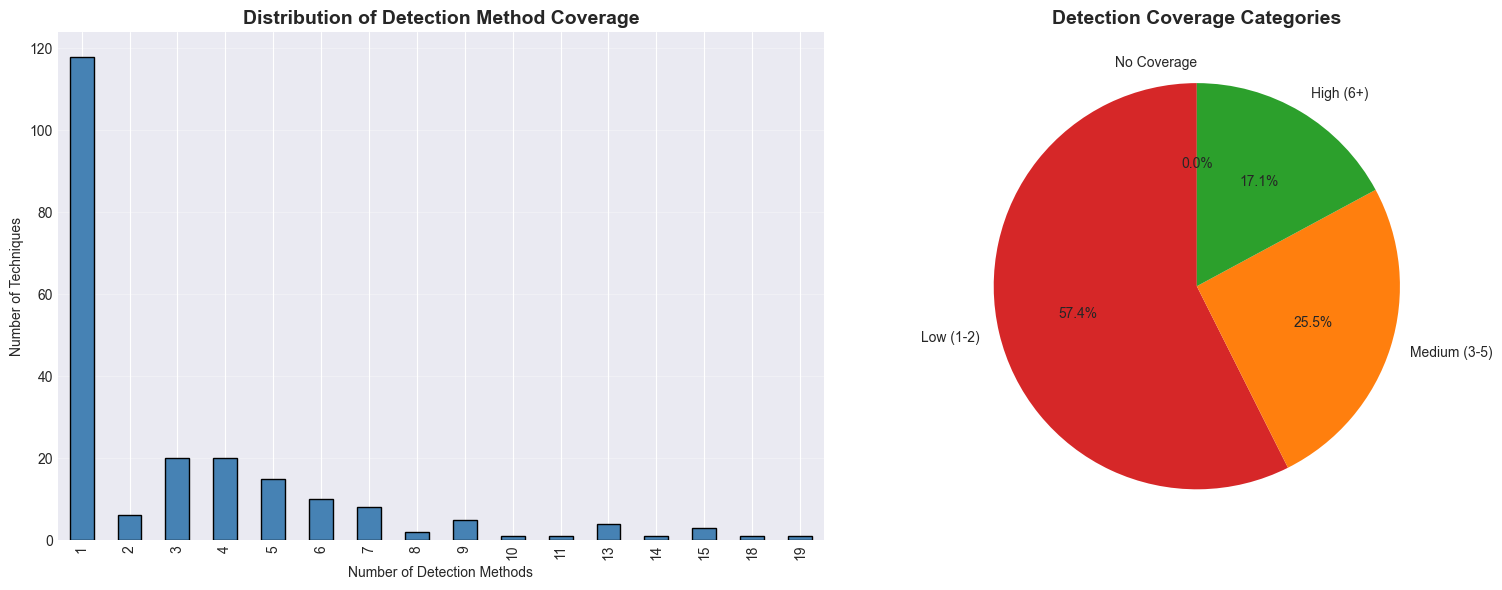


⚠️ Security Implication:
   Techniques with limited/no detection methods represent blind spots!
   Many techniques lack documented detection strategies, highlighting
   the challenge of comprehensive threat detection.


In [ ]:
# ============================================================================
# VISUALIZE DETECTION COVERAGE
# ============================================================================
# Purpose: Create visual representations of detection gaps
#
# Two visualizations:
# 1. Distribution of detection method counts (bar chart)
# 2. Coverage categories breakdown (pie chart)

print("\n📊 Creating detection coverage visualizations...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------------------------------------------------
# Chart 1: Distribution of Detection Method Counts
# -----------------------------------------------------------------------
# Shows: How many techniques have 0, 1, 2, 3... detection methods

detection_counts = detection_df['Detection_Methods'].value_counts().sort_index()

detection_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Distribution of Detection Method Coverage\n' +
             'How many detection methods exist per technique?', 
             fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Detection Methods', fontsize=11)
ax1.set_ylabel('Number of Techniques', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Add count labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fontsize=9)

# -----------------------------------------------------------------------
# Chart 2: Coverage Categories (Pie Chart)
# -----------------------------------------------------------------------
# Categorizes techniques into coverage levels:
# - No Coverage: 0 methods
# - Low: 1-2 methods
# - Medium: 3-5 methods
# - High: 6+ methods

coverage_categories = pd.cut(
    detection_df['Detection_Methods'], 
    bins=[-1, 0, 2, 5, 100], 
    labels=['No Coverage (0)', 'Low (1-2)', 'Medium (3-5)', 'High (6+)']
)
coverage_counts = coverage_categories.value_counts()

# Colors: Red (bad) to Blue (good)
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']

ax2.pie(coverage_counts, labels=coverage_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 10})
ax2.set_title('Detection Coverage Categories\n' +
             'What percentage of techniques have adequate coverage?', 
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# Interpretation Guide
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 HOW TO USE THESE INSIGHTS")
print("="*80 + "\n")

print("📌 Understanding the Charts:")
print("   Left Chart (Bar):")
print("      • Each bar = How many techniques have that many detection methods")
print("      • Large bar at '0' = Many techniques with no detection (red flag!)")
print("      • Tall bars on right side = Good coverage for those techniques")
print()
print("   Right Chart (Pie):")
print("      • Red slice = Techniques with NO detection methods")
print("      • Orange slice = Techniques with minimal detection (1-2 methods)")
print("      • Green/Blue = Better detection coverage")
print()

print("⚠️  Critical Security Implications:")
print("   1. Techniques with NO or LOW coverage are blind spots")
print("      → Attackers can use these with reduced risk of detection")
print()
print("   2. Many legitimate techniques lack detection methods because:")
print("      • They overlap with normal user/admin activity")
print("      • Required telemetry is expensive or invasive")
print("      • Detection would generate excessive false positives")
print()
print("   3. Limited detection ≠ Can't detect")
print("      • You can still use behavioral analytics")
print("      • Correlate with other techniques (attack chains)")
print("      • Focus on high-fidelity data sources")
print()

print("🎯 Recommended Actions:")
print("   1. Cross-reference this with technique popularity analysis:")
print("      • Popular + Low Detection = CRITICAL GAP (address immediately)")
print("      • Rare + Low Detection = Lower priority (accept risk or monitor)")
print()
print("   2. For high-priority gaps:")
print("      • Review available data sources (logs, EDR, network)")
print("      • Implement compensating controls")
print("      • Add to threat hunting rotation")
print()
print("   3. Set realistic expectations:")
print("      • 100% detection coverage is impossible")
print("      • Focus on: Initial Access, Credential Access, Lateral Movement")
print("      • Build layered defenses (defense-in-depth)")

print(f"\n{'='*80}")
print("✓ Detection gap analysis complete")
print(f"{'='*80}")

---

## 📚 Summary & Key Takeaways

### 🎓 What You've Learned:

This notebook taught you how to **programmatically analyze ATT&CK data** - a critical skill for security analysts, threat intelligence professionals, and detection engineers.

---

### ✅ Skills & Concepts Covered:

#### 1. **Threat Group Profiling** (Part 2)
**What you learned:**
- How to extract complete TTP patterns for specific APT groups
- How to organize techniques by tactic (Kill Chain phases)
- How to compare multiple groups to identify behavioral patterns

**Real-world application:**
- Respond to threat intelligence reports mentioning specific APT groups
- Build threat actor profiles for executive briefings
- Prioritize defenses based on adversary capabilities

**Key insight:** Different threat groups have different "signatures" - patterns in which tactics they emphasize and which techniques they prefer.

---

#### 2. **Technique Popularity Analysis** (Part 3)
**What you learned:**
- How to identify the most commonly used techniques across ALL threat groups
- How to quantify technique prevalence (% of groups using each technique)
- How to prioritize defenses based on popularity

**Real-world application:**
- Build a "Top 10" list of techniques to defend against
- Justify security investments to management (ROI of defending popular techniques)
- Train SOC analysts on the techniques they're most likely to encounter

**Key insight:** Popular techniques (like PowerShell, Credential Dumping, Phishing) should be **highest priority** for detection because they're:
- Used by many different threat groups
- Proven effective and reliable (from attacker perspective)
- Represent the broadest threat surface

---

#### 3. **Software (Malware/Tools) Analysis** (Part 4)
**What you learned:**
- How to profile specific malware and tools documented in ATT&CK
- How to identify "versatile" tools that implement many techniques
- The difference between malware (malicious) and tools (legitimate, but misused)

**Real-world application:**
- Rapidly assess capabilities when new malware is detected
- Prioritize alerts (detection of versatile tools = higher priority)
- Understand what to hunt for after initial compromise

**Key insight:** Tools like Cobalt Strike, Mimikatz, and PowerShell Empire are "Swiss Army knives" for attackers - they implement dozens of techniques and should trigger immediate investigation when detected.

---

#### 4. **Detection Gap Analysis** (Part 5)
**What you learned:**
- How to identify techniques with limited or no detection methods
- How to quantify detection coverage across the ATT&CK matrix
- Which techniques are marked as "difficult to detect" by MITRE

**Real-world application:**
- Identify blind spots in your security monitoring
- Prioritize investment in logging/telemetry
- Set realistic expectations about detection capabilities
- Build compensating controls where direct detection is hard

**Key insight:** Many techniques lack documented detection methods because:
- They overlap with legitimate activity (high false positive rates)
- Required telemetry is expensive or invasive to collect
- Techniques are specifically designed to evade detection

**Critical gap:** When a **popular technique** (used by many groups) **also has poor detection coverage**, that's a **CRITICAL security gap** requiring immediate attention.

---

### 🎯 Practical Applications in Your Career:

| Role | How to Use This Notebook |
|------|-------------------------|
| **Security Analyst** | Profile threat groups mentioned in intelligence reports; understand capabilities of detected malware |
| **Detection Engineer** | Prioritize detection rule development based on technique popularity; identify coverage gaps |
| **Threat Intelligence** | Automate threat actor profiling; track TTPs of groups targeting your industry |
| **Incident Responder** | Quickly look up adversary TTPs during active investigations; predict next attack stages |
| **Purple Team Lead** | Select relevant TTPs for testing; design realistic adversary emulation exercises |
| **Security Manager** | Build data-driven security roadmaps; justify budget for detection/monitoring tools |

---

### 🚀 Next Steps:

#### **Notebook 3: Applied Analysis & Detection**
In the next notebook, we'll take these skills further:
- **Map real-world attacks** to ATT&CK (case study analysis)
- **Reconstruct attack scenarios** using Kill Chain + ATT&CK
- **Build detection rules** based on specific TTPs
- **Create coverage heatmaps** for your organization
- **Design purple team exercises** based on threat intelligence

---

### 💪 Practice Exercises (Try These on Your Own):

#### **Exercise 1: Profile Your Sector's Threats**
1. Research which APT groups target your industry (financial, healthcare, government, etc.)
2. Use the `profile_threat_group()` function to analyze each group
3. Identify common techniques across these groups
4. Build a prioritized defense plan

#### **Exercise 2: Custom Popularity Analysis**
Modify the popularity analysis to focus only on techniques relevant to your environment:
- Filter by specific tactics (e.g., only Initial Access + Credential Access)
- Exclude techniques you can't realistically detect
- Create a custom "Top 10" for your organization

#### **Exercise 3: Tool Inventory Mapping**
1. List all security tools in your environment (EDR, SIEM, network monitoring, etc.)
2. For each tool, identify which ATT&CK data sources it provides
3. Map coverage to techniques
4. Identify gaps and overlaps

#### **Exercise 4: Detection Prioritization Matrix**
Combine popularity data with detection gaps to create a prioritized backlog:
- **Critical Priority:** High popularity + Low detection coverage
- **High Priority:** High popularity + Medium detection coverage
- **Medium Priority:** Medium popularity + Low detection coverage
- **Low Priority:** Low popularity + High detection coverage

---

### 📚 Additional Resources for Deeper Learning:

#### **Official MITRE Resources:**
- **ATT&CK Website:** https://attack.mitre.org/
- **ATT&CK Groups:** https://attack.mitre.org/groups/ (browse all threat groups)
- **ATT&CK Software:** https://attack.mitre.org/software/ (malware and tools database)
- **ATT&CK Tactics:** https://attack.mitre.org/tactics/enterprise/ (understand each tactic)

#### **Detection & Analytics:**
- **MITRE Cyber Analytics Repository (CAR):** https://car.mitre.org/
  - Pre-built analytics for detecting ATT&CK techniques
  - Includes pseudocode and implementation examples
- **ATT&CK Navigator:** https://mitre-attack.github.io/attack-navigator/
  - Interactive heatmap tool for visualizing coverage

#### **Python & STIX:**
- **STIX Python Library:** https://stix2.readthedocs.io/
  - Official documentation for working with STIX data
- **ATT&CK Scripts Repository:** https://github.com/mitre-attack/attack-scripts
  - Example scripts and utilities from MITRE

#### **Threat Intelligence:**
- **ATT&CK Blog:** https://medium.com/mitre-attack
  - Case studies, research, and technique spotlights
- **ATT&CK Evaluations:** https://attackevals.mitre-engenuity.org/
  - Independent evaluations of security vendor detection capabilities

---

### 🎉 Congratulations!

You've completed **Notebook 02: Programmatic Analysis**! 

You now have the skills to:
- ✅ Query and analyze ATT&CK data programmatically
- ✅ Profile threat groups and understand their TTPs
- ✅ Identify high-priority techniques for your defenses
- ✅ Analyze malware capabilities
- ✅ Discover gaps in detection coverage

**You're now ready to move on to Notebook 03**, where we'll apply these skills to real-world attack scenarios and build actionable detection strategies.

---

### 💡 Remember:

> **"The goal is not to detect everything, but to detect what matters."**

Focus your limited resources on:
1. Popular techniques (used by many threat groups)
2. Techniques targeting your critical assets
3. Techniques that provide high-fidelity detections
4. Techniques early in the Kill Chain (prevent, not just detect)

Happy analyzing! 🚀